In [1]:
from cfl.experiment import Experiment
import numpy as np
import pandas as pd
from cfl.visualization.basic_visualizations import visualize_macrostates

2024-12-06 01:17:47.037110: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data_1km = pd.read_csv('data/1km_data.csv')
X = np.array(data_1km[['long', 'lat']])
Y = np.array(data_1km['generated_temp']).reshape(-1,1)
print(X.shape, Y.shape)

(1273630, 2) (1273630, 1)


In [3]:
# Create 3 dictionaries: one for data info, one with CDE parameters, and one with cluster parameters

# the parameters should be passed in dictionary form
data_info = {'X_dims' : X.shape,
             'Y_dims' : Y.shape,
             'Y_type' : 'continuous' #options: 'categorical' or 'continuous'
            }

# pass in empty parameter dictionaries to use the default parameter values (not
# allowed for data_info)
CDE_params = {  'model'        : 'CondExpMod',
                'model_params' : {
                    # model architecture
                    'dense_units' : [50, data_info['Y_dims'][1]],
                    'activations' : ['relu', 'linear'],
                    'dropouts'    : [0, 0],
                    # training parameters
                    'batch_size'  : 32,
                    'n_epochs'    : 11,
                    'optimizer'   : 'adam',
                    'opt_config'  : {'learning_rate' : 1e-4},
                    'loss'        : 'mean_squared_error',
                    'best'        : True,
                    # verbosity
                    'verbose'     : 1,
                    'show_plot'   : True,
                }
}

# cluster_params consists of specifying two clustering objects
# CFL automatically recognizes the names of all sklearn.cluster models as keywords
cause_cluster_params =  {'model' : 'KMeans',
                         'model_params' : {'n_clusters' : 9},
                         'verbose' : 0
}
effect_cluster_params = {'model' : 'KMeans',
                         'model_params' : {'n_clusters' : 9},
                         'verbose' : 0
}

In [4]:
# block_names indicates which CDE and clustering models to use
block_names = ['CondDensityEstimator', 'CauseClusterer', 'EffectClusterer']

# block_params is aligned to block_names
block_params = [CDE_params, cause_cluster_params, effect_cluster_params]

results_path = 'sample_run' # directory to save results to

# Create a new CFL experiment with specified parameters
my_exp = Experiment(X_train=X,
                    Y_train=Y,
                    data_info=data_info,
                    block_names=block_names,
                    block_params=block_params,
                    results_path=results_path)

All results from this run will be saved to sample_run/experiment0004
Block: verbose not specified in input, defaulting to 1
CondExpBase: activity_regularizers not specified in input, defaulting to None
CondExpBase: kernel_regularizers not specified in input, defaulting to None
CondExpBase: bias_regularizers not specified in input, defaulting to None
CondExpBase: kernel_initializers not specified in input, defaulting to None
CondExpBase: bias_initializers not specified in input, defaulting to None
CondExpBase: weights_path not specified in input, defaulting to None
CondExpBase: tb_path not specified in input, defaulting to None
CondExpBase: optuna_callback not specified in input, defaulting to None
CondExpBase: optuna_trial not specified in input, defaulting to None
CondExpBase: early_stopping not specified in input, defaulting to False
CondExpBase: checkpoint_name not specified in input, defaulting to tmp_checkpoints


In [5]:
results = my_exp.train()

#################### Beginning CFL Experiment training. ####################
Beginning CondDensityEstimator training...
No GPU device detected.
Epoch 1/11
10049/29851 [=========>....................] - ETA: 25s - loss: 9.5894

KeyboardInterrupt: 

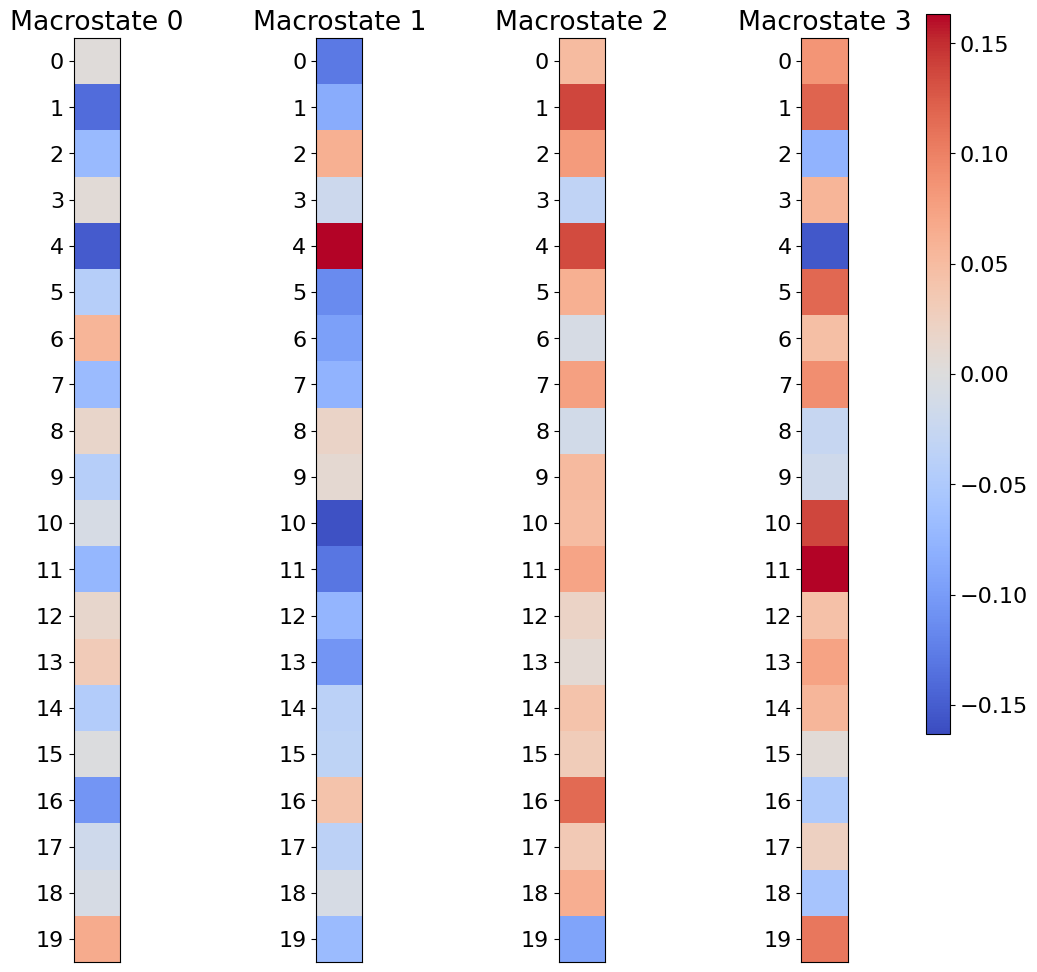

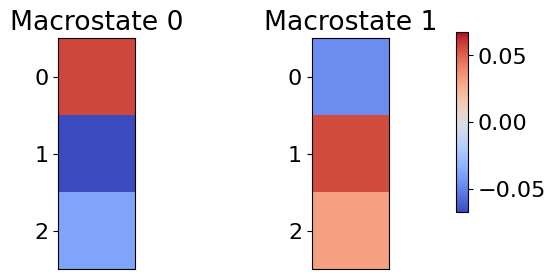

In [ ]:
# visualize cause macrostates
visualize_macrostates(  data=X,
                        feature_names=None,
                        cause_or_effect='cause',
                        exp_path=my_exp.get_save_path(),
                        data_series='dataset_train',
                        subtract_global_mean=True)

# visualize effect macrostates
visualize_macrostates(  data=Y,
                        feature_names=None,
                        cause_or_effect='effect',
                        exp_path=my_exp.get_save_path(),
                        data_series='dataset_train',
                        subtract_global_mean=True)